In [19]:
import nilearn
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
import nibabel as nib
import numpy as np
import pandas
import os
import glob
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from nilearn import plotting
from matplotlib import pyplot as plt
from nilearn import input_data
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
import scipy
import pickle

In [1]:
len(['014', '020', '021', '024', '027', '033', '043', '058', '028', '029', '031', '032', '034', '036', '037', '045', '046', '049', '050', '060', '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', '083', '084', '085', '086', '088', '089', '094', '095', '098', '099', '100', '101'])

42

In [20]:
def model_connectome(ts_list, ts_labels, subject_set, C = 1, n_splits = 10, fconn_types = ['correlation', 'partial correlation', 'tangent', 'covariance', 'precision'], plot_scores = True):
    # If ts_list | ts_labels are a dictionary, collapse them into a list
    if type(ts_labels) == dict:
        ts_labels = {k: ts_labels[k] for k in ts_labels.keys() & subject_set}
        ts_list = {k: ts_list[k] for k in ts_list.keys() & subject_set}
        ts_labels = [item for sublist in list(ts_labels.values()) for item in sublist]
        ts_list = [item for sublist in list(ts_list.values()) for item in sublist]
        
    # Define and run the Model
    _, classes = np.unique(ts_labels, return_inverse=True)  # Convert accuracy into numpy array of binary labels
    ts_array = np.asarray(ts_list) # Convert list of time series into a numpy array of time series

    # Define correlation types
    kinds = fconn_types
    _, classes = np.unique(ts_labels, return_inverse=True)
    cv = StratifiedShuffleSplit(n_splits=n_splits, random_state=0, test_size=0.3)
    ts_array = np.asarray(ts_list)

    scores = {}

    for kind in kinds:
        scores[kind] = []
        for train, test in cv.split(ts_array, classes):
            connectivity = ConnectivityMeasure(kind = kind, vectorize = True) # We vectorize the Functional Connectivity, so it is easier to run the SVC classifier on
            connectomes = connectivity.fit_transform(ts_array[train])

            classifier = LinearSVC(C = C).fit(connectomes, classes[train])
            predictions = classifier.predict(connectivity.transform(ts_array[test]))
            scores[kind].append(accuracy_score(classes[test], predictions)) 
    
    if plot_scores:
        chance_level = np.mean(ts_labels)
        print('CHANCE: ', chance_level)
        mean_scores = [np.mean(scores[kind]) for kind in kinds]
        print('MEAN MODEL ACC: ', mean_scores)
        scores_std = [np.std(scores[kind]) for kind in kinds]
    
        plt.figure(figsize=(6, 4))
        positions = np.arange(len(kinds)) * .1 + .1
        plt.barh(positions, mean_scores, align='center', height=.05, xerr=scores_std)
        yticks = [k.replace(' ', '\n') for k in kinds]
        plt.yticks(positions, yticks)
        plt.gca().grid(True)
        plt.gca().set_axisbelow(True)
        plt.gca().axvline(chance_level, color='red', linestyle='--')
        plt.xlabel('Classification accuracy\n(red line = chance level)')
        plt.tight_layout()

    return(scores)

In [ ]:
with open('X_MLINDIV-DL_251_80_rest.pickle', 'rb') as handle:
    sub_X_dict = pickle.load(handle)

with open('Y_MLINDIV-DL_251_80_rest.pickle', 'rb') as y_handle:
    sub_Y_dict = pickle.load(y_handle)

error_dict = {}
good_subs = []
for subject in sub_X_dict.keys():
    try:
        model_connectome(sub_X_dict, sub_Y_dict, {subject}, C = 1, n_splits = 10, fconn_types = ['tangent']) 
    except Exception as e:
        error_dict[subject] = e
        # For error messages that begin with Th, we include them. These errors go away when model runs as a batch
        if 'Th' in str(e):
            good_subs.append(subject)
    else: 
        good_subs.append(subject)
        
print(good_subs)
error_dict
set(good_subs)

Run the above cell to find the good subjects who don't break the model when their connectomes are calculated.
Otherwise, use the below list:

['014', '020', '021', '024', '027', '033', '043', '058', '028', '029', '031', '032', '034', '036', '037', '045', '046', '049', '050', '060', '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', '083', '084', '085', '086', '088', '089', '094', '095', '098', '099', '100', '101']

In [21]:
def return_Xy_data(ts_list, ts_labels, subject_set):
    if type(ts_labels) == dict:
        ts_labels = {k: ts_labels[k] for k in ts_labels.keys() & subject_set}
        ts_list = {k: ts_list[k] for k in ts_list.keys() & subject_set}
        ts_labels = [item for sublist in list(ts_labels.values()) for item in sublist]
        ts_list = [item for sublist in list(ts_list.values()) for item in sublist]
        
    # Define and run the Model
    _, classes = np.unique(ts_labels, return_inverse=True)  # Convert accuracy into numpy array of binary labels
    ts_array = np.asarray(ts_list) # Convert list of time series into a numpy array of time series
    
    _, classes = np.unique(ts_labels, return_inverse=True)
    ts_array = np.asarray(ts_list)
    
    return ts_array, classes
    

In [22]:
with open('X_MLINDIV-DL_251_80_rest.pickle', 'rb') as handle:
    sub_X_dict = pickle.load(handle)

with open('Y_MLINDIV-DL_251_80_rest.pickle', 'rb') as y_handle:
    sub_Y_dict = pickle.load(y_handle)
    
good_subs = ['014', '020', '021', '024', '027', '033', '043', '058', '028', '029', '031', '032', '034', '036', '037', '045',
             '046', '049', '050', '060', '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', '083', '084', 
             '085', '086', '088', '089', '094', '095', '098', '099', '100', '101']

X, y = return_Xy_data(sub_X_dict, sub_Y_dict, set(good_subs))

connectivity = ConnectivityMeasure(kind = 'correlation') # We vectorize the Functional Connectivity, so it is easier to run the SVC classifier on
v_conn = ConnectivityMeasure(kind = 'correlation', vectorize = True, discard_diagonal=True)



/opt/jupyterhub/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


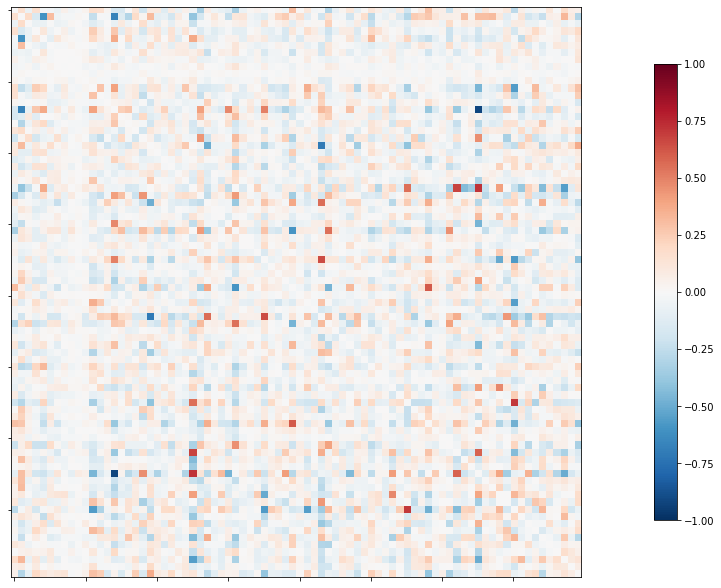

In [72]:
connectivity = ConnectivityMeasure(kind = 'tangent')

connectomes = connectivity.fit_transform([X[35])[0]
np.fill_diagonal(connectomes, 0)

plotting.plot_matrix(connectomes, figure=(10, 8),
                     vmax=1, vmin=-1)

v_connectome = v_conn.fit_transform([X[35]])[0]

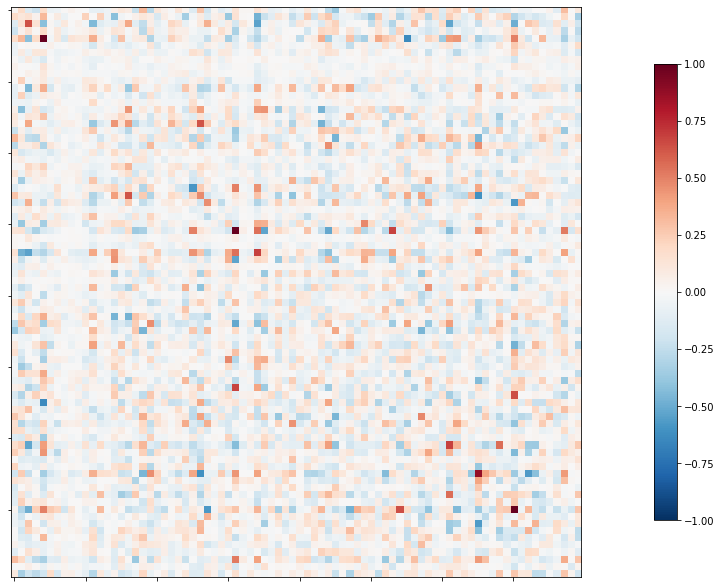

In [75]:
tangent_measure = ConnectivityMeasure(kind = 'tangent')
tangent_matrices = tangent_measure.fit_transform(X)

plotting.plot_matrix(tangent_matrices[35], figure=(10, 8),
                     vmax=1, vmin=-1)

In [ ]:
kinds = ['tangent', 'correlation', 'covariance', 'precision', 'partial correlation']

scores, perm_scores, pvalues = {}, {}, {}

clf = LinearSVC(C = 0.005)
cv = StratifiedKFold(2, shuffle=True, random_state=0)
for kind in kinds:
    connectivity = ConnectivityMeasure(kind = kind, vectorize = True, discard_diagonal=True)
    connectomes = connectivity.fit_transform(X)
    print("-----------------------------------------------------------------------------------------------")
    
    scores[kind], perm_scores[kind], pvalues[kind] = permutation_test_score(clf, connectomes, y, scoring="accuracy", cv=cv, n_permutations=1000, verbose=1, n_jobs=20)
    print('%s-based Connectivity Predictive Model Performance \n\tModel Score:\t\t\t%.3f \n\tMean Permutation Score:\t\t%.3f \n\tp-value:\t\t\t%.3f' % (kind.title(), scores[kind], np.mean(perm_scores[kind]), pvalues[kind]))

In [13]:
for kind in kinds:
    print('%s-based Connectivity Predictive Model Performance \n\tModel Score:\t\t\t%.3f \n\tMean Permutation Score:\t\t%.3f \n\tp-value:\t\t\t%.3f' % (kind.title(), scores[kind], np.mean(perm_scores[kind]), pvalues[kind]))

Tangent-based Connectivity Predictive Model Performance 
	Model Score:			0.769 
	Mean Permutation Score:		0.539 
	p-value:			0.001
Correlation-based Connectivity Predictive Model Performance 
	Model Score:			0.718 
	Mean Permutation Score:		0.520 
	p-value:			0.001
Covariance-based Connectivity Predictive Model Performance 
	Model Score:			0.682 
	Mean Permutation Score:		0.513 
	p-value:			0.001
Precision-based Connectivity Predictive Model Performance 
	Model Score:			0.585 
	Mean Permutation Score:		0.585 
	p-value:			1.000
Partial Correlation-based Connectivity Predictive Model Performance 
	Model Score:			0.648 
	Mean Permutation Score:		0.585 
	p-value:			0.001


In [23]:
def best_model(ts_array, classes, kind, C, n_splits):
    scores = []
    high_score = 0
    cv = StratifiedShuffleSplit(n_splits=n_splits, random_state=0, test_size=0.3)
    count = 0
    
    
    for train, test in cv.split(ts_array, classes):
            connectivity = ConnectivityMeasure(kind = kind, vectorize = True, discard_diagonal = True) # We vectorize the Functional Connectivity, so it is easier to run the SVC classifier on
            connectomes = connectivity.fit_transform(ts_array[train])

            classifier = LinearSVC(C = C).fit(connectomes, classes[train])
            predictions = classifier.predict(connectivity.transform(ts_array[test]))
            acc_score = accuracy_score(classes[test], predictions)
            scores.append(acc_score) 
            
            if acc_score > high_score:
                best_model = classifier
                high_score = acc_score
                
            count += 1
            pct_complete = (count/n_splits) * 100
            print("%0.3f Percent Complete" % pct_complete,  end = "\r", flush = True)
    
    return scores, best_model
            
            

In [ ]:
scores, best_model = best_model(X, y, 'tangent', 0.005, 100)

In [4]:
accuracy_score(y, best_model.predict(connectivity.transform(X)))

NameError: name 'y' is not defined

In [25]:
connectivity = ConnectivityMeasure(kind = 'tangent', vectorize = True, discard_diagonal = True)
connectivity.fit_transform(X)

def create_binned_performance(X, y, model, connectivity):
    window_size, true_accuracy, pred_accuracy, correct_prediction = [], [], [], []
    
    for index, connectome in enumerate(X):
        window_size.append(connectome.shape[0])
        true_accuracy.append(y[index])
        pred_accuracy.append(best_model.predict(connectivity.transform([X[index]]))[0])
        correct_prediction.append(y[index] == best_model.predict(connectivity.transform([X[index]]))[0])
    
    d = {'window_size': window_size, 'true_acc': true_accuracy, 'pred_acc': pred_accuracy, 'correct_prediction': correct_prediction}
    best_model_df = pandas.DataFrame(d)
    return best_model_df
    

best_model_df = create_binned_performance(X, y, best_model, connectivity)

In [24]:
with open('ML-80-model-acc89.sav', 'rb') as mod:
    best_model = pickle.load(mod)

In [32]:
np.mean(best_model_df.window_size) * .72

34.981214574898786

R: 0.079	p-value: 0.537
R: -0.014	p-value: 0.537


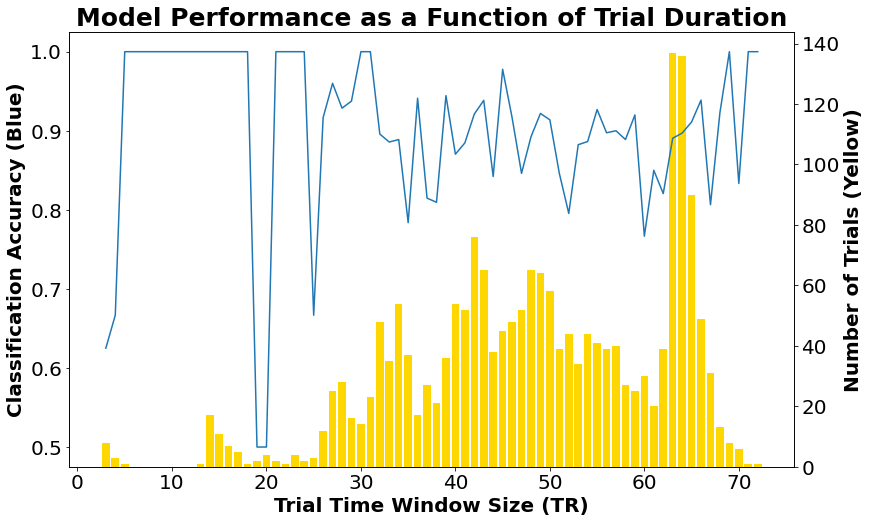

In [88]:
q_num = 20

size_by_correct = best_model_df[['window_size', 'correct_prediction']].groupby('window_size').mean()
size_by_correct['number'] = best_model_df[['window_size', 'correct_prediction']].groupby('window_size').count()
size_by_correct['acc'] = best_model_df[['window_size', 'true_acc']].groupby('window_size').mean()

sbc = size_by_correct[size_by_correct.number >= 0]



r, p = scipy.stats.pearsonr(list(sbc.index), sbc.correct_prediction)
print("R: %.3f\tp-value: %.3f" % (r, p))

fig = plt.figure(figsize=(13, 8), facecolor = 'white')
ax1 = fig.add_subplot(111)
ax1.plot(list(sbc.index), sbc.correct_prediction, zorder = 1)
ax1.set_ylabel('Classification Accuracy (Blue)', fontweight = 'bold', fontsize = 20)


ax2 = ax1.twinx()
ax2.bar(list(sbc.index), sbc.number, color = 'gold')
ax2.set_ylabel('Number of Trials (Yellow)', fontweight = 'bold', fontsize = 20)

ax1.set_xlabel('Trial Time Window Size (TR)', fontweight = 'bold', fontsize = 20)
labels = pandas.qcut(list(sbc.index), q=q_num).unique()
ax1.set_zorder(10)
ax1.patch.set_visible(False)
plt.title("Model Performance as a Function of Trial Duration", fontweight = 'bold', fontsize = 25)

ax1.tick_params(axis='both', labelsize = 20)
plt.yticks(fontsize = 20)


r, p = scipy.stats.pearsonr(best_model_df.window_size, best_model_df.correct_prediction)
print("R: %.3f\tp-value: %.3f" % (r, p))

plt.savefig('tan_perf_trialduration.png')



In [55]:
pandas.set_option("display.max_rows", None, "display.max_columns", None)
sbc

,correct_prediction,number,acc
window_size,,,
3,0.625000,8,0.000000
4,0.666667,3,0.000000
5,1.000000,1,0.000000
13,1.000000,1,1.000000
14,1.000000,17,0.705882
15,1.000000,11,1.000000
16,1.000000,7,0.571429
17,1.000000,5,0.400000
18,1.000000,1,0.000000


In [10]:
import nilearn
from nilearn import datasets
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure
from nilearn import plotting
import nibabel as nib
import numpy as np
import pandas
import os
import glob
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from nilearn import plotting
from matplotlib import pyplot as plt
from nilearn import input_data
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import permutation_test_score
import scipy
import pickle

In [11]:
def return_Xy_data(ts_list, ts_labels, subject_set):
    if type(ts_labels) == dict:
        ts_labels = {k: ts_labels[k] for k in ts_labels.keys() & subject_set}
        ts_list = {k: ts_list[k] for k in ts_list.keys() & subject_set}
        ts_labels = [item for sublist in list(ts_labels.values()) for item in sublist]
        ts_list = [item for sublist in list(ts_list.values()) for item in sublist]
        
    # Define and run the Model
    _, classes = np.unique(ts_labels, return_inverse=True)  # Convert accuracy into numpy array of binary labels
    ts_array = np.asarray(ts_list) # Convert list of time series into a numpy array of time series
    
    _, classes = np.unique(ts_labels, return_inverse=True)
    ts_array = np.asarray(ts_list)
    
    return ts_array, classes
    

In [12]:
with open('X_MLINDIV-DL_251_80_rest.pickle', 'rb') as handle:
    sub_X_dict = pickle.load(handle)

with open('Y_MLINDIV-DL_251_80_rest.pickle', 'rb') as y_handle:
    sub_Y_dict = pickle.load(y_handle)
    
good_subs = ['014', '020', '021', '024', '027', '033', '043', '058', '028', '029', '031', '032', '034', '036', '037', '045',
             '046', '049', '050', '060', '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', '083', '084', 
             '085', '086', '088', '089', '094', '095', '098', '099', '100', '101']

X, y = return_Xy_data(sub_X_dict, sub_Y_dict, set(good_subs))

connectivity = ConnectivityMeasure(kind = 'correlation') # We vectorize the Functional Connectivity, so it is easier to run the SVC classifier on
v_conn = ConnectivityMeasure(kind = 'correlation', vectorize = True, discard_diagonal=True)


/opt/jupyterhub/lib/python3.6/site-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


Tangent Linear SVC Mean Accuracy: 76.953% +/-(0.007)
Correlation Linear SVC Mean Accuracy: 72.500% +/-(0.010)


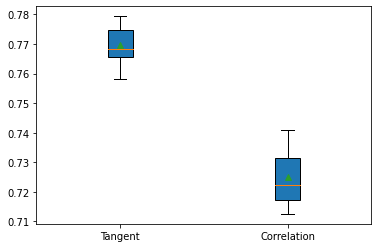

In [13]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import cross_val_score


# evaluate model 1
model1 = LinearSVC(C=0.005)

tan_connectivity = ConnectivityMeasure(kind = 'tangent', vectorize = True, discard_diagonal=True)
tangent_connectomes = tan_connectivity.fit_transform(X)

cv1 = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 5, random_state = 1)
scores1 = cross_val_score(model1, tangent_connectomes, y, scoring = 'accuracy', cv = cv1, n_jobs = -1)
print('Tangent Linear SVC Mean Accuracy: %.3f%% +/-(%.3f)' % (np.mean(scores1*100), np.std(scores1)))

# evaluate model 2
model2 = LinearSVC(C=0.005)

corr_connectivity = ConnectivityMeasure(kind = 'correlation', vectorize = True, discard_diagonal=True)
corr_connectomes = corr_connectivity.fit_transform(X)

cv2 = RepeatedStratifiedKFold(n_splits = 2, n_repeats = 5, random_state = 1)
scores2 = cross_val_score(model2, corr_connectomes, y, scoring = 'accuracy', cv = cv2, n_jobs = -1)
print('Correlation Linear SVC Mean Accuracy: %.3f%% +/-(%.3f)' % (np.mean(scores2*100), np.std(scores2)))

# plot the results
dict_scores = {'Tangent': scores1, 
              'Correlation': scores2}


plt.boxplot([scores1, scores2], labels=['Tangent', 'Correlation'], showmeans=True, patch_artist=True)
plt.show()

In [14]:
good_subs = ['014', '020', '021', '024', '027', '033', '043', '058', '028', '029', '031', '032', '034', '036', '037', '045',
             '046', '049', '050', '060', '062', '065', '068', '069', '070', '071', '072', '074', '081', '082', '083', '084', 
             '085', '086', '088', '089', '094', '095', '098', '099', '100', '101']
len(good_subs)

42

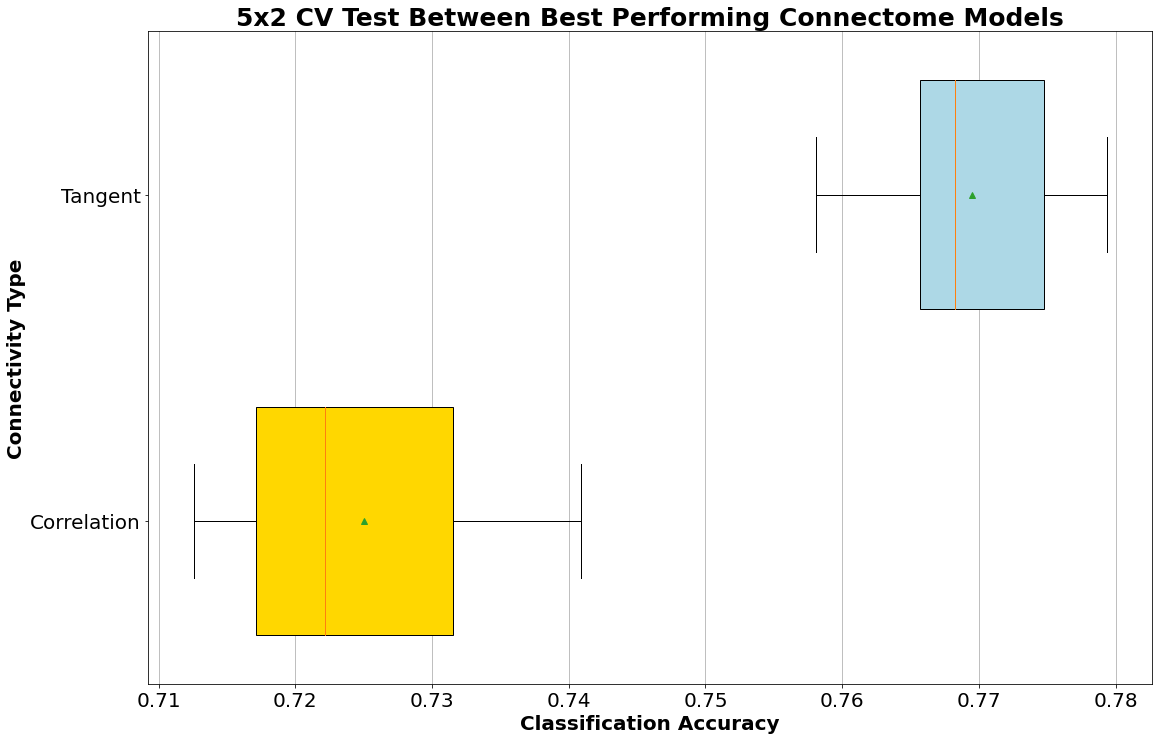

In [94]:
plt.figure(figsize=(18, 12), facecolor = 'white')
bplot = plt.boxplot([scores2, scores1], labels=['Correlation', 'Tangent'], showmeans=True, patch_artist=True, vert=False, widths = 0.7)
colors = ['gold', 'lightblue']

for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)


plt.gca().xaxis.grid(True)
plt.xticks(fontsize = 20)

plt.yticks(fontsize = 20)
plt.title('5x2 CV Test Between Best Performing Connectome Models', fontweight = 'bold', fontsize = 25)
plt.xlabel('Classification Accuracy', fontweight = 'bold', fontsize = 20)
plt.ylabel('Connectivity Type', fontweight = 'bold', fontsize = 20)
plt.gca().set_axisbelow(True)

plt.savefig('5x2cv.png')

In [16]:
from scipy import stats

print("Tangent Distribution: " + str(stats.shapiro(scores1)))
print("Correlation Distribution: " + str(stats.shapiro(scores2)))
print('Degrees of Freedom: ' + str(len(scores1) - 1))

print('\nPaired T-Test Results: ' + str(stats.ttest_rel(scores1, scores2)))

w, p = stats.wilcoxon(scores1 - scores2)
print('Wilcoxon Signed-Rank Test Results: ' + str(stats.wilcoxon(scores1 - scores2)))

Tangent Distribution: ShapiroResult(statistic=0.9378916025161743, pvalue=0.5298002362251282)
Correlation Distribution: ShapiroResult(statistic=0.9131231904029846, pvalue=0.3031406104564667)
Degrees of Freedom: 9

Paired T-Test Results: Ttest_relResult(statistic=15.914013131623578, pvalue=6.742123478473364e-08)
Wilcoxon Signed-Rank Test Results: WilcoxonResult(statistic=0.0, pvalue=0.001953125)


In [17]:
#Compute the difference between the results
diff = [y - x for y, x in zip(scores1, scores2)]
#Comopute the mean of differences
d_bar = np.mean(diff)
#compute the variance of differences
sigma2 = np.var(diff)
#compute the number of data points used for training 
n1 = len(y)/2
#compute the number of data points used for testing 
n2 = len(y)/2
#compute the total number of data points
n = len(y)
#compute the modified variance
sigma2_mod = sigma2 * (1/n + n2/n1)
#compute the t_static
t_static =  d_bar / np.sqrt(sigma2_mod)
from scipy.stats import t
#Compute p-value and plot the results 
Pvalue = ((1 - t.cdf(t_static, n-1))*200)
print('Paired Corrected Resampled T-Test Results: \nT-statistic = %.3f \t p-value = %f' % (t_static, Pvalue))

Paired Corrected Resampled T-Test Results: 
T-statistic = 5.303 	 p-value = 0.000013
